## Classification of Handwritten Digits

Written by: Kane Cunningham, 06/2015

This project explores methods for classifying handwritten digits from the MNIST data set as given in a long-term, no-prize Kaggle competition. Hand written digits are digitized as 8-bit grayscale images, 28x28 pixels. Each image is therefore represented as a 784-element vector of integers, each in the range 0-255. The data set contains 42,000 images. So, while the number of images is relatively small, the dimensionality is relatively high.

The goal was to test a variety of classifiers alone and combined with dimensionality reduction. The general strategy was to first test a variety of classifiers, then test classifiers with dimensionality reduction, and then choose the final model and make final refinements. 

Note that state of the art classifiers for handwritten digits depend on pre-processing methods such as rotation relative to an estimated central axis. Such methods are not considered for this exercise.

There is a lot of cross-validated grid search in this notebook that can be very time-intensive. In practice, I usually do some initial probing with 1 or 2 parameters and a smaller training sample in order to establish a reasonable search range before implementing the final search. This help avoid unnecessarily large Cartesian products.

### Setup: dependencies and loading data

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn.base as base
from sklearn.decomposition import RandomizedPCA, ProjectedGradientNMF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import grid_search
from sklearn.linear_model import SGDClassifier, SGDRegressor, LinearRegression
from scipy.spatial.distance import cosine, euclidean
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
import time

In [2]:
# For plotting inline
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [3]:
# read file
filename = 'train.csv'

labels = []
features = []
with open(filename, 'r') as f:
    readr = csv.reader(f)
    next(readr)
    for line in readr:
        labels.append(int(line[0]))
        features.append([int(x) for x in line[1:]])

### Logistic Regression Classifier
Cross-validated grid search on a SGD classifier gave logisitic regression with L1 regularization as the optimal parameters. This relatively simple model has an out-of-sample accuracy of 0.89.


In [224]:
log_clf = SGDClassifier(loss='log', penalty='l1', alpha=0.0001,\
                    fit_intercept=True, n_iter=15, warm_start=True)

log_clf_GS = grid_search.GridSearchCV(log_clf, param_grid = \
                                  dict(loss=['log'],\
        alpha=[10**x for x in range(-5,-3,1)]),\
                                    n_jobs=4, verbose=1)
log_clf_GS.fit(features,labels)
print(log_clf_GS.best_params_)
print(log_clf_GS.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:  6.3min finished


{'alpha': 0.0001, 'loss': 'log'}
0.890833333333


In [225]:
log_clf_opt = SGDClassifier(loss='log', penalty='l1', alpha=10**(-4),\
                    fit_intercept=True, n_iter=30, warm_start=True)

log_clf_opt.fit(features,labels)
log_clf_opt.score(features,labels)

0.90523809523809529

### C-SVM Classifier
C-Support Vector Machine. Cross-validated accuracy is considerably higher than logistic regression at 0.97. The model is somewhat slow and may not scale well.

In [43]:
svc_clf = SVC(C=1.0,kernel='poly',degree=2)
my_cv = ShuffleSplit(len(features),n_iter=3,test_size=0.3,train_size=0.6)

svc_clf_CV = grid_search.GridSearchCV(svc_clf,param_grid = dict(C=[0.6,0.7,0.8],\
                                                        degree=[2],\
                                                      gamma=[0,1.2/784,0.8/784]),\
                                                    cv=my_cv,\
                                                    n_jobs=4,\
                                                    verbose = 1)
svc_clf_CV.fit(features,labels)
print(svc_clf_CV.best_params_)
print(svc_clf_CV.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  21 out of  27 | elapsed: 22.3min remaining:  6.4min
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 28.2min finished


{'C': 0.7, 'gamma': 0, 'degree': 2}
0.973703703704


In [ ]:
svc_clf_opt = SVC(kernel='poly',C=0.7,degree=2,gamma=0)
svc_clf_opt.fit(features,labels)

### K Nearest Neighbors Classifier

In [ ]:
# Initial grid search to estimate n_neighbors param
KN_clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto',\
                    leaf_size=30, p=2, metric='minkowski')
my_cv = ShuffleSplit(len(features),n_iter=3,test_size=0.3,train_size=0.6)

KN_clf_CV = grid_search.GridSearchCV(KN_clf,param_grid = dict(n_neighbors=[1,2,3],\
                                                        p=[1]),\
                                                    cv=my_cv,\
                                                    n_jobs=4,\
                                                    verbose = 1)
KN_clf_CV.fit(features,labels)
print(KN_clf_CV.best_params_)
print(KN_clf_CV.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [ ]:
KN_clf_CV.grid_scores_

### Adding dimensionality reduction (PCA)
Randomized PCA is used to reduce the dimenionality before applying the optimized SVC classifier. A cross-validated parameter search is used to determine the optimal number of components. The results indicate that N=60 is the optimal value and the accuracy is comparable to the SVC classifier used on the the full feature set.

In [61]:
pca = RandomizedPCA(n_components=500, whiten=True)
svc_clf_opt = SVC(kernel='poly',C=0.7,degree=2,gamma=0)
pca_clf = Pipeline([
        ('pca', pca),
        ('clf', svc_clf_opt)
        ])

In [71]:
my_cv = ShuffleSplit(len(features),n_iter=3,test_size=0.2,train_size=0.7)
pca_clf_CV = grid_search.GridSearchCV(pca_clf,\
                        param_grid = dict(pca__n_components=[5,10,20,40,60,80,100,140,200]),\
                                                    cv=my_cv,\
                                                    n_jobs=4,\
                                                    verbose = 1)
pca_clf_CV.fit(features,labels)
print(pca_clf_CV.best_params_)
print(pca_clf_CV.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  21 out of  27 | elapsed: 21.2min remaining:  6.1min
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 31.5min finished


{'pca__n_components': 60}
0.97623015873


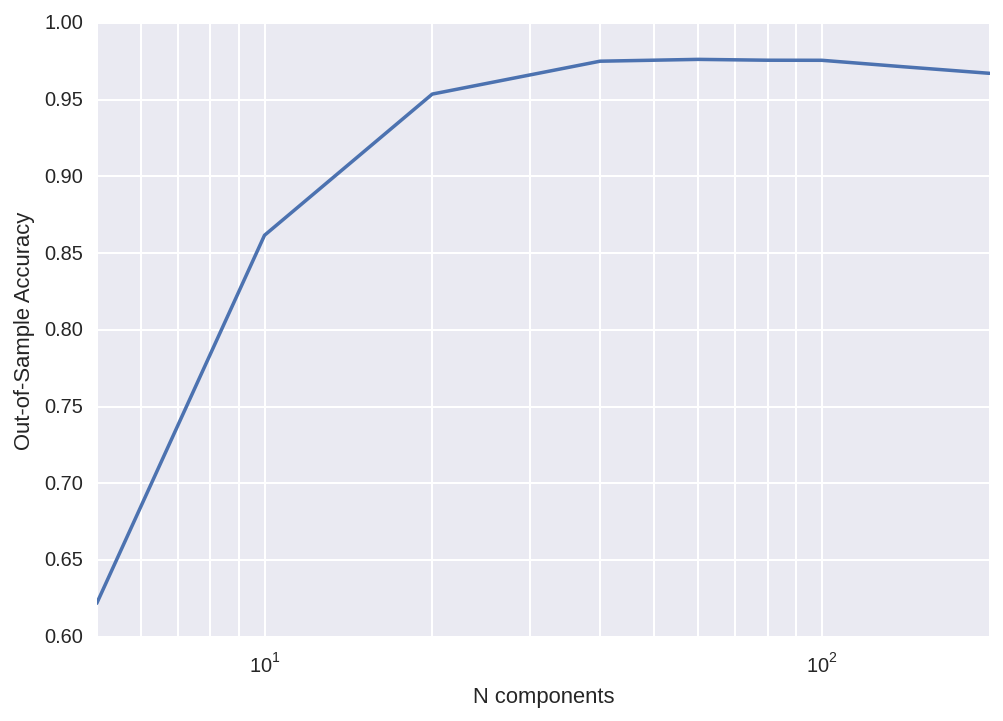

In [112]:
df = pd.DataFrame(pca_clf_CV.grid_scores_,columns=['N','accuracy','scores'])
df['N components']=[x.values()[0] for x in df['N']]
my_plt = pd.Series(df['accuracy'].tolist(),index=df['N components']).plot(logx=True)
my_plt.set_ylabel('Out-of-Sample Accuracy')

####How does adding PCA effect execution time?
Table for fit and predict methods using full data set (42,000 entries)

| METHOD | NO PCA | WITH PCA |       
| :-: |:-------------: | :-:
|FIT| 194.82 s | 81.57 s
| PREDICT| 330.57 s  | 48.97 s

The predict method runs 6.6x faster when dimensionality reduction is included

Timing for SVC model alone:

In [127]:
# Optimized SVC model
svc_clf_opt_noPCA = SVC(kernel='poly',C=0.7,degree=2,gamma=0)

In [128]:
# Measure fit time with no PCA
start = time.clock()
svc_clf_opt.fit(features,labels)
end = time.clock()
print "Fit time : %f" % (end-start)

# Measure predict time with no PCA
start = time.clock()
svc_clf_opt.predict(features)
end = time.clock()
print "Predict time : %f" % (end-start)

Fit time : 194.822201
Predict time : 330.572687


Timiing for model with PCA:

In [114]:
# Optimized PCA model
pca = RandomizedPCA(n_components=60, whiten=True)
svc_clf_opt = SVC(kernel='poly',C=0.7,degree=2,gamma=0)
pca_clf_opt = Pipeline([
        ('pca', pca),
        ('clf', svc_clf_opt)
        ])

In [126]:
# Measure fit time with PCA
start = time.clock()
pca_clf_opt.fit(features,labels)
end = time.clock()
print "Fit time : %f" % (end-start)

# Measure predict time with PCA
start = time.clock()
pca_clf_opt.predict(features)
end = time.clock()
print "Predict time : %f" % (end-start)

Fit time : 81.570246
Predict time : 48.969121


###NMF v. PCA
Is one form of dimensionality reduction preferred in this case?

In [10]:
nmf_trans = ProjectedGradientNMF(n_components = 10, init='nndsvd', beta=1)
svc_nmf_clf = SVC(kernel='poly',C=0.7,degree=2,gamma=0)
nmf_clf = Pipeline([
        ('nmf', nmf_trans),
        ('clf', svc_nmf_clf)
        ])

In [16]:
my_cv = ShuffleSplit(len(features),n_iter=3,test_size=0.2,train_size=0.6)
nmf_clf_CV = grid_search.GridSearchCV(nmf_clf,\
                        param_grid = dict(nmf__n_components=[10,20,40,60,100],\
                                                    nmf__beta=[1]),\
                                                    cv=my_cv,\
                                                    n_jobs=4,\
                                                    verbose = 1)
nmf_clf_CV.fit(features,labels)
print(nmf_clf_CV.best_params_)
print(nmf_clf_CV.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 128.4min finished


{'nmf__n_components': 40, 'nmf__beta': 1}
0.948095238095


In [17]:
nmf_clf_CV.grid_scores_

[mean: 0.87917, std: 0.00356, params: {'nmf__n_components': 10, 'nmf__beta': 1},
 mean: 0.94611, std: 0.00202, params: {'nmf__n_components': 20, 'nmf__beta': 1},
 mean: 0.94810, std: 0.00103, params: {'nmf__n_components': 40, 'nmf__beta': 1},
 mean: 0.93984, std: 0.00208, params: {'nmf__n_components': 60, 'nmf__beta': 1},
 mean: 0.91163, std: 0.01179, params: {'nmf__n_components': 100, 'nmf__beta': 1}]

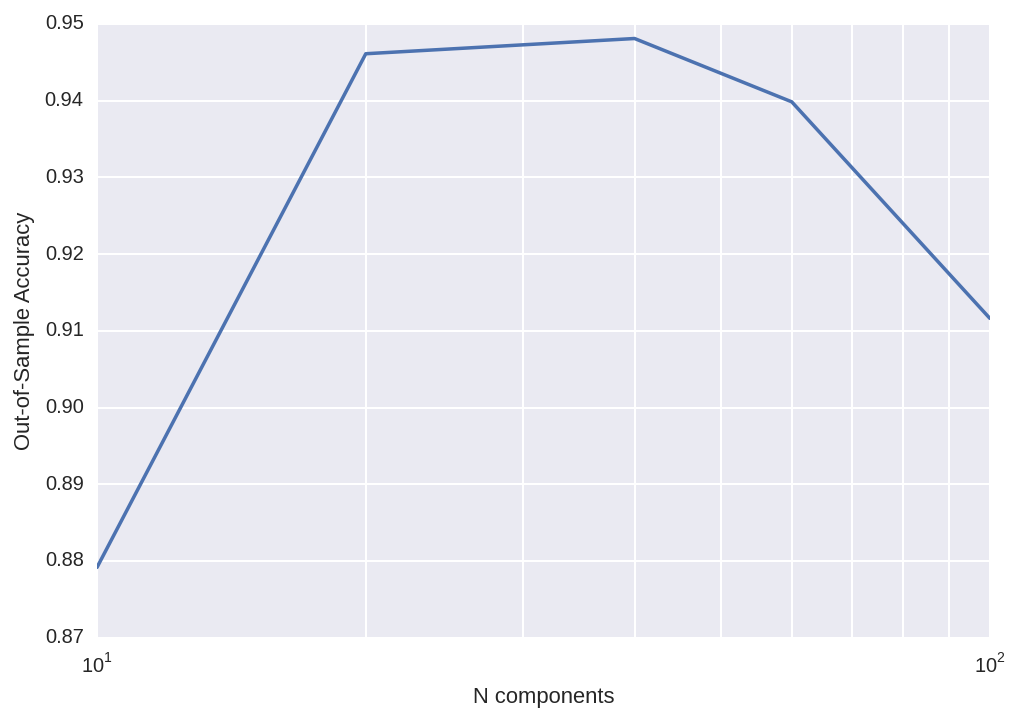

In [19]:
df = pd.DataFrame(nmf_clf_CV.grid_scores_,columns=['N','accuracy','scores'])
df['N components']=[x.values()[0] for x in df['N']]
my_plt = pd.Series(df['accuracy'].tolist(),index=df['N components']).plot(logx=True)
my_plt.set_ylabel('Out-of-Sample Accuracy')

In [5]:
# Optimized classifier
nmf_trans = ProjectedGradientNMF(n_components = 30, init='nndsvd', beta=1)
svc_nmf_clf_opt = SVC(kernel='poly',C=0.7,degree=2,gamma=0)
nmf_clf_opt = Pipeline([
        ('nmf', nmf_trans),
        ('clf', svc_nmf_clf)
        ])

####Timing for NMF v. PCA
Table for fit and predict methods using full data set (42,000 entries)

| METHOD | SVC | WITH PCA | WITH NMF       
| :------------: |:-------------: | :-: | :-: |
|FIT| 194.82 s | 81.57 s | 1059.88 s |
| PREDICT| 330.57 s  | 48.97 s | 71.80 s |

NMF is considerably slower with comparable accuracy at best

NMF execution time:

In [6]:
# Measure fit time with NMF
start = time.clock()
nmf_clf_opt.fit(features,labels)
end = time.clock()
print "Fit time : %f" % (end-start)

# Measure predict time with NMF
start = time.clock()
nmf_clf_opt.predict(features)
end = time.clock()
print "Predict time : %f" % (end-start)

Fit time : 1059.883515
Predict time : 71.800812


/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/nmf.py:533: UserWarning: Iteration limit reached during fit
  warnings.warn("Iteration limit reached during fit")


####NMF v. PCA Conclusions
The conclusion here is that randomized PCA performs better than projected gradient NMF for this data set in terms of both accuracy and execution time. Fit times for projected gradient NMF are too slow for rigorous cross-validated grid search to be practical.